# A. Introduction
**This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.**
* sex: female or male
* age: of the patient.
* classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
* degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
* patient type: hospitalized or not hospitalized.
* pneumonia: whether the patient already have air sacs inflammation or not.
* pregnancy: whether the patient is pregnant or not.
* diabetes: whether the patient has diabetes or not.
* copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
* asthma: whether the patient has asthma or not.
* inmsupr: whether the patient is immunosuppressed or not.
* hypertension: whether the patient has hypertension or not.
* cardiovascular: whether the patient has heart or blood vessels related disease.
* renal chronic: whether the patient has chronic renal disease or not.
* other disease: whether the patient has other disease or not.
* obesity: whether the patient is obese or not.
* tobacco: whether the patient is a tobacco user.
* usmr: Indicates whether the patient treated medical units of the first, second or third level.
* medical unit: type of institution of the National Health System that provided the care.
* intubed: whether the patient was connected to the ventilator.
* icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
* death: indicates whether the patient died or recovered.

**The main goal of this project is to build a machine learning model that, given a Covid-19 patient's current symptom, status, and medical history, will predict whether the patient is in high risk or not.**

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [65]:
!pip install xgboost

In [66]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import StratifiedShuffleSplit

In [3]:
df = pd.read_csv("covid19_data.csv")

In [4]:
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-null  int64 
 15

# B. Data Processing
1. Description already stated: _In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data._, we will eliminate all "missing data"

In [6]:
df.nunique()

USMER                     2
MEDICAL_UNIT             13
SEX                       2
PATIENT_TYPE              2
DATE_DIED               401
INTUBED                   4
PNEUMONIA                 3
AGE                     121
PREGNANT                  4
DIABETES                  3
COPD                      3
ASTHMA                    3
INMSUPR                   3
HIPERTENSION              3
OTHER_DISEASE             3
CARDIOVASCULAR            3
OBESITY                   3
RENAL_CHRONIC             3
TOBACCO                   3
CLASIFFICATION_FINAL      7
ICU                       4
dtype: int64

First, look into SEX columns:

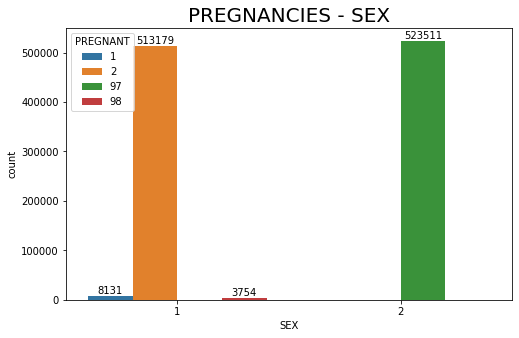

In [7]:
plt.figure(figsize = (8,5))
ax = sns.countplot(df.SEX, hue = df.PREGNANT)
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("PREGNANCIES - SEX", fontsize = 20);

**In pregnancies, 98 means null values for female and 97 means null values for males. We will convert 97 to 2 because men can't birth.**

In [8]:
df.PREGNANT = df.PREGNANT.replace(97, 2)

Moreover, we look into INTUBED and ICU:

In [9]:
df.INTUBED.value_counts(normalize=True)

97    0.809235
2     0.151682
1     0.032097
99    0.006986
Name: INTUBED, dtype: float64

In [10]:
df.ICU.value_counts(normalize=True)

97    0.809235
2     0.167546
1     0.016077
99    0.007141
Name: ICU, dtype: float64

Most of them (**80.9%**) are missing data. So they should be drop. 

In [11]:
df.drop("INTUBED", axis = 1, inplace = True)
df.drop("ICU", axis = 1, inplace = True)

The other ones that still have missing value are:

In [12]:
contains_missing_value_cols = df.loc[:, df.nunique() == 3].columns

In [13]:
for col in contains_missing_value_cols:
    df = df[(df[col] == 1) | (df[col] == 2)]

With the objective: predict whether the patient is in high risk or not given the current status of the patients, DATE_DIED doesn't tell us a lot of information. Therefore, it would be dropped either.

In [14]:
df.drop("DATE_DIED", axis = 1, inplace = True)

Now, look into target class CLASIFFICATION_FINAL:

In [15]:
df.CLASIFFICATION_FINAL.value_counts()

7    488706
3    377378
6    117342
5     25245
1      8417
4      3088
2      1801
Name: CLASIFFICATION_FINAL, dtype: int64

We know that: **1-2-3 means COVID and 4-5-6-7 means not COVID**. So we convert like that:

In [16]:
df.CLASIFFICATION_FINAL = df.CLASIFFICATION_FINAL.replace([1,2,3], 0)
df.CLASIFFICATION_FINAL = df.CLASIFFICATION_FINAL.replace([4,5,6,7], 1)

In [17]:
df.CLASIFFICATION_FINAL.value_counts(normalize=True)

1    0.620739
0    0.379261
Name: CLASIFFICATION_FINAL, dtype: float64

In [30]:
df.shape

(1021977, 18)

This is a very huge dataset. For represtative manner, I'll pick 10.000 samples

In [31]:
feature_cols = df.columns[df.columns != 'CLASIFFICATION_FINAL']

strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=1010997, 
                                          random_state=7)

new_df_ind, _ = next(strat_shuf_split.split(df[feature_cols], df.CLASIFFICATION_FINAL))

# Create the dataframes
new_df = df.iloc[new_df_ind]
new_df.shape

(10980, 18)

In [33]:
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=7)
train_idx, test_idx = next(strat_shuf_split.split(new_df[feature_cols], new_df.CLASIFFICATION_FINAL))
train_set = new_df.iloc[train_idx]
test_set = new_df.iloc[test_idx]
X_train = train_set[feature_cols]
y_train = train_set['CLASIFFICATION_FINAL']

X_test  = test_set[feature_cols]
y_test  = test_set['CLASIFFICATION_FINAL']

In [35]:
y_train.value_counts(normalize=True)

1    0.620739
0    0.379261
Name: CLASIFFICATION_FINAL, dtype: float64

# C. Building Model

In [45]:
from sklearn.model_selection import GridSearchCV
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='binary')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    results_pos['roc_auc_score'] = roc_auc_score(yt, yp)
    return results_pos

def general_report(model, name, param_grid = dict(), cv = 2, scoring = 'accuracy', n_jobs=-1):
    # The grid search object
    grid = GridSearchCV(model, 
                          param_grid=param_grid, 
                          scoring=scoring, cv = cv,
                          n_jobs=n_jobs)

    # Do the grid search
    grid = grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    print(f"___{name} Model Report___")
    print(evaluate_metrics(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    _, ax = plt.subplots()
    sns.heatmap(cm, ax=ax, annot=True, fmt='d');
    ax.set(title=name);
    return grid
    

## Logistic Regression Model

___Logistic Regression Model Report___
{'accuracy': 0.651183970856102, 'recall': 0.9046454767726161, 'precision': 0.6597717546362339, 'f1score': 0.7630439265828005, 'roc_auc_score': 0.5704172139667724}
              precision    recall  f1-score   support

           0       0.60      0.24      0.34      1249
           1       0.66      0.90      0.76      2045

    accuracy                           0.65      3294
   macro avg       0.63      0.57      0.55      3294
weighted avg       0.64      0.65      0.60      3294



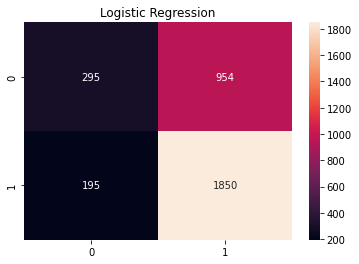

In [48]:
lr = LogisticRegression(solver='liblinear')
param_grid = {
    "penalty": ['l1', 'l2', 'Lasso']
}
lr_model = general_report(lr, name="Logistic Regression", cv=4)

___K Nearest Neighboor Model Report___
{'accuracy': 0.5740740740740741, 'recall': 0.6987775061124695, 'precision': 0.64485559566787, 'f1score': 0.6707345693499179, 'roc_auc_score': 0.534336711422928}
              precision    recall  f1-score   support

           0       0.43      0.37      0.40      1249
           1       0.64      0.70      0.67      2045

    accuracy                           0.57      3294
   macro avg       0.54      0.53      0.53      3294
weighted avg       0.56      0.57      0.57      3294



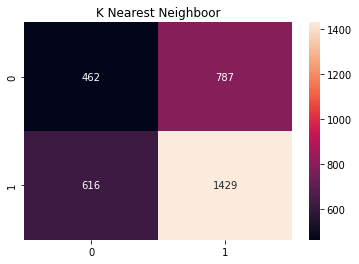

In [39]:
knn = KNeighborsClassifier(weights='distance')
param_grid = {
    "n_neighbors": [i for i in range(5, 49, 2)]
}
knn_model = general_report(knn, name="K Nearest Neighboor", n_jobs=3, cv=3)

## Support Vector Machine

___Support Vector Machine Model Report___
{'accuracy': 0.655130540376442, 'recall': 0.9398533007334964, 'precision': 0.654855195911414, 'f1score': 0.7718875502008032, 'roc_auc_score': 0.5644022308311196}
              precision    recall  f1-score   support

           0       0.66      0.19      0.29      1249
           1       0.65      0.94      0.77      2045

    accuracy                           0.66      3294
   macro avg       0.66      0.56      0.53      3294
weighted avg       0.66      0.66      0.59      3294



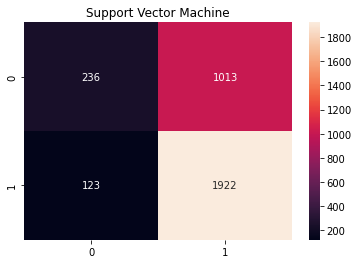

In [40]:
svc = SVC(probability=True)
param_grid = {
    'C': [1, 10, 100],
    'kernel': ['poly', 'rbf', 'sigmoid']
}
svc_model = general_report(model=svc, name="Support Vector Machine", param_grid=param_grid, cv=5)

## Tree and Ensemble

___Random Forest Classifier Model Report___
{'accuracy': 0.6523982999392836, 'recall': 0.9261613691931541, 'precision': 0.6558171745152355, 'f1score': 0.7678897222785324, 'roc_auc_score': 0.5651623499288428}
              precision    recall  f1-score   support

           0       0.63      0.20      0.31      1249
           1       0.66      0.93      0.77      2045

    accuracy                           0.65      3294
   macro avg       0.64      0.57      0.54      3294
weighted avg       0.65      0.65      0.59      3294



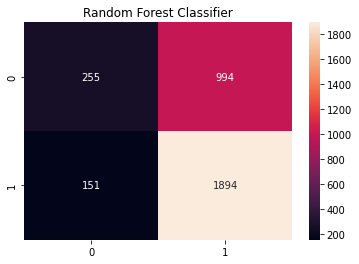

In [59]:
random_forest = RandomForestClassifier()
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
             'max_depth' : [2*n+1 for n in range(10) ],
             'max_features':["auto", "sqrt", "log2"]}
rf_model = general_report(model=random_forest, name= "Random Forest Classifier", param_grid=param_grid)

___AdaBoost Classifier Model Report___
{'accuracy': 0.6514875531268974, 'recall': 0.9129584352078239, 'precision': 0.6580895311949242, 'f1score': 0.7648504711183941, 'roc_auc_score': 0.5681685690850969}
              precision    recall  f1-score   support

           0       0.61      0.22      0.33      1249
           1       0.66      0.91      0.76      2045

    accuracy                           0.65      3294
   macro avg       0.63      0.57      0.55      3294
weighted avg       0.64      0.65      0.60      3294



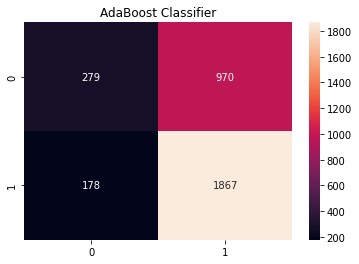

In [50]:
tree = AdaBoostClassifier()
param_grid = {'learning_rate': [0.1*(n+1) for n in range(10)],
             'n_estimators' : [2*n+1 for n in range(10)],
              'algorithm':['SAMME', 'SAMME.R']}                
tree_model = general_report(model=tree, name = "AdaBoost Classifier", param_grid=param_grid)

___Bagging Classifier Model Report___
{'accuracy': 0.6517911353976927, 'recall': 0.9114914425427872, 'precision': 0.6586572438162545, 'f1score': 0.7647179487179487, 'roc_auc_score': 0.5690363537773984}
              precision    recall  f1-score   support

           0       0.61      0.23      0.33      1249
           1       0.66      0.91      0.76      2045

    accuracy                           0.65      3294
   macro avg       0.63      0.57      0.55      3294
weighted avg       0.64      0.65      0.60      3294



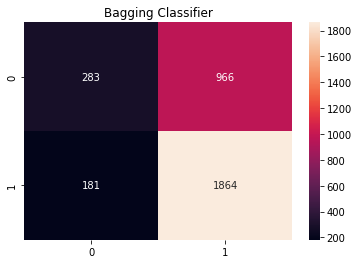

In [58]:
bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=7),n_estimators=10,random_state=7,bootstrap=True)
param_grid = {'n_estimators': [2*n+1 for n in range(20)],
     'base_estimator__max_depth' : [2*n+1 for n in range(10) ] }
bag_model = general_report(model=bag, name = "Bagging Classifier", param_grid=param_grid, scoring='accuracy', cv=3)

___Stacking Classifier Model Report___
{'accuracy': 0.6569520340012144, 'recall': 0.9315403422982885, 'precision': 0.6580310880829016, 'f1score': 0.7712550607287448, 'roc_auc_score': 0.56945311750623}
              precision    recall  f1-score   support

           0       0.65      0.21      0.31      1249
           1       0.66      0.93      0.77      2045

    accuracy                           0.66      3294
   macro avg       0.65      0.57      0.54      3294
weighted avg       0.65      0.66      0.60      3294



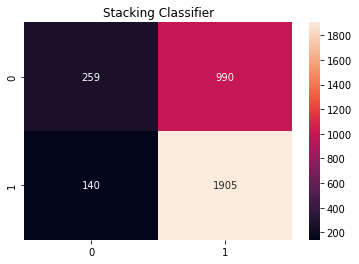

In [67]:
estimators = [('SVM',SVC(random_state=42)),('knn',KNeighborsClassifier()),('dt',DecisionTreeClassifier())]
stacking = StackingClassifier( estimators=estimators, final_estimator= LogisticRegression())
param_grid = {
    'dt__max_depth': [n for n in range(10)],
    'dt__random_state':[0],
    'SVM__C':[0.01,0.1,1],
    'knn__n_neighbors':[5,7,9] 
}
stacking_model = general_report(model=stacking, name = "Stacking Classifier", param_grid=param_grid, cv=3)

___XGB Classifier Model Report___
{'accuracy': 0.6445051608986035, 'recall': 0.878239608801956, 'precision': 0.6607799852832965, 'f1score': 0.7541465462943523, 'roc_auc_score': 0.5700245281800013}
              precision    recall  f1-score   support

           0       0.57      0.26      0.36      1249
           1       0.66      0.88      0.75      2045

    accuracy                           0.64      3294
   macro avg       0.61      0.57      0.56      3294
weighted avg       0.63      0.64      0.60      3294



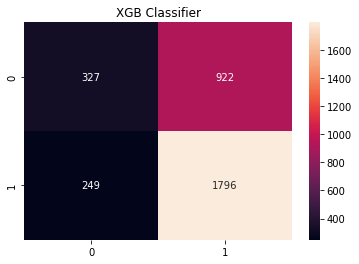

In [68]:
xgb = XGBClassifier(objective='binary:logistic')
param_grid = {'learning_rate': [0.1*(n+1) for n in range(5)],
             'n_estimators' : [100, 200, 300],
             'eval_metric': ["error", "mlogloss"]}
xgb_model = general_report(model=xgb, name="XGB Classifier", param_grid=param_grid, cv=3)

As we can see that the models above show approximately the same with each other. There may be several suggestions:
- The mini data_set that we extract was too small to represent the population.
- Those feature doesn't have enough predictive power to predict the risk of a patient.

Let's look a bit to xgb model and linear regression model:

In [91]:
coef = lr_model.best_estimator_.coef_.ravel()
importance_feature = pd.DataFrame({"feature": feature_cols, "coef": coef})
importance_feature.sort_values(by=["coef"])

,feature,coef
3,PATIENT_TYPE,-0.393952
15,RENAL_CHRONIC,-0.323330
9,ASTHMA,-0.295391
12,OTHER_DISEASE,-0.257647
8,COPD,-0.252616
2,SEX,-0.221830
16,TOBACCO,-0.174782
0,USMER,-0.101332
5,AGE,-0.009450
10,INMSUPR,0.021597


In [87]:
xgb_model.best_estimator_.feature_importances_.shape

(17,)

In [90]:
df_importances = pd.DataFrame(feature_cols, xgb_model.best_estimator_.feature_importances_)
df_importances.columns = ["Feature_Names"]
df_importances["Importances"] = df_importances.index
df_importances = df_importances.sort_values(by = "Importances", ascending = False)
df_importances.index = np.arange(0,len(df_importances))
df_importances

,Feature_Names,Importances
0,PATIENT_TYPE,0.247347
1,PNEUMONIA,0.157864
2,OBESITY,0.060100
3,PREGNANT,0.053396
4,OTHER_DISEASE,0.043980
5,AGE,0.041818
6,HIPERTENSION,0.041023
7,ASTHMA,0.040811
8,COPD,0.040597
9,RENAL_CHRONIC,0.037882


We can see that 2 models indicate PNEUMONIA, OBESITY and PATIENT_TYPE are 3 most indicative powerful to estimate the risk.
The 2 models that have a little bit more outstanding than the other are stacking model and SVC model. If we look into stacking model:

In [92]:
stacking_model.best_estimator_.final_estimator_.n_features_in_

3

**We can see it indicates 3 feature. Eventhough we cannot clarify but guessing the 3 above is quite resonable.**